In [1]:
import cv2
import yaml
import os
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.nn import functional as F

import onnx
import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

#### 모델 로딩
- 모델부 수정함

In [2]:
from models import *
 
model_path  = "../saved_models/isnet-general-use.pth"  # the model path
input_size  = [1024,1024]
net         = ISNetDIS()

if torch.cuda.is_available():
    net.load_state_dict(torch.load(model_path))
    net = net.cuda()
else:
    net.load_state_dict(torch.load(model_path,map_location="cpu"))
net.eval()

print('모델 로딩 완')

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


모델 로딩 완


In [3]:
# onnx 모델 저장 경로
os.makedirs('./onnx_models/', exist_ok=True)
onnx_model_path = './onnx_models/isnet_.onnx'
device    = torch.device('cuda')
dummy_inputs = {
    "input" : torch.as_tensor(np.ones([1, 3, 1024, 1024]), dtype = torch.float32).to(device)
}
output_names = ["output"]

torch.onnx.export(
        model=net,                            # 실행될 모델
        args = tuple(dummy_inputs.values()),        # 모델 입력값(tuple or 여러 입력값)
        f = onnx_model_path,                     # 모델 저장 경로
        export_params=True,                 # 모델 파일 안에 학습된 모델 가중치 저장 여부
        opset_version=13,                   # 모델 변환할 때 사용할 onnx 버전
        do_constant_folding = True,         # 최적화시 상수폴딩 사용할지 여부
        input_names=list(dummy_inputs.keys()),
        output_names=output_names,
        dynamic_axes={
            'input'     : {0 : 'batch_size'},    # 가변적인 길이를 가진 차원
            'output'    : {0 : 'batch_size'}
        }
    ) 

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [4]:
onnx_model_quantized_path = "./onnx_models/isnet_quant.onnx"
quantize_dynamic(
    model_input=onnx_model_path,
    model_output=onnx_model_quantized_path,
    #optimize_model=True,
    per_channel=False,
    reduce_range=False,
    weight_type=QuantType.QUInt8,
)

#### ONNX-Runtime Test

In [50]:
onnx_model_quantized_path = "./onnx_models/postprocessing4_quant.onnx"
# loading
ort_session = onnxruntime.InferenceSession(onnx_model_quantized_path, providers=['AzureExecutionProvider'])
input_size  = [1024,1024]
img = np.float32(cv2.imread('./luka.jpg'))
original_shape = img.shape
im_shp=img.shape[0:2]
im_tensor = torch.tensor(img, dtype=torch.float32).permute(2,0,1)
im_tensor = F.upsample(torch.unsqueeze(im_tensor,0), input_size, mode="bilinear").type(torch.uint8)
image = torch.divide(im_tensor,255.0)

from torchvision.transforms.functional import normalize
image = normalize(image,[0.5,0.5,0.5],[1.0,1.0,1.0])

image_embedding = image.detach().cpu().numpy()

# 테스트 실행
ort_inputs  = {ort_session.get_inputs()[0].name : image_embedding}
#print(ort_inputs)
ort_outputs = ort_session.run(None, ort_inputs)

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


True

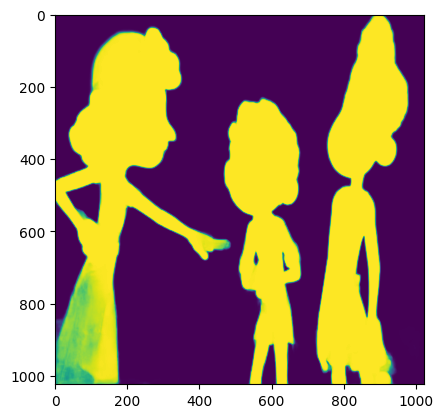

In [55]:
img = ort_outputs[0]
plt.imshow(img)

saveImg = cv2.cvtColor(img * 255, cv2.COLOR_GRAY2BGR)
saveImg = cv2.resize(saveImg, dsize=(original_shape[1], original_shape[0]))
cv2.imwrite('./result.png', saveImg)